<a href="https://colab.research.google.com/github/Anna-Simmi/FUTURE_DS_03/blob/main/College_event.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Install necessary libraries (run once in Colab)
!pip install -q pandas matplotlib seaborn textblob vaderSentiment wordcloud
# download TextBlob corpora
!python -m textblob.download_corpora -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [2]:
# 2) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import re
sns.set(style="whitegrid")

In [5]:
# 3) Load data (two options)
# Option A: Upload file interactively (Colab)
from google.colab import files
uploaded = files.upload()  # select your CSV

# Option B: Load from Google Drive (if you prefer)
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('/content/drive/MyDrive/path/to/feedback.csv')

# After uploading (Option A), read the first uploaded file:
import io
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))

# Quick peek
df.head()

Saving sample_event_feedback.csv to sample_event_feedback.csv


,Timestamp,EventType,Department,Rating,Comments
0,2025-07-30 08:37:00,Cultural Fest,ECE,1,Too crowded and unorganized.
1,2025-07-31 14:26:00,Photography Contest,CSE,4,Excellent arrangements and hospitality.
2,2025-07-10 19:17:00,Hackathon,Civil,5,Great organization and very informative.
3,2025-07-30 18:07:00,Hackathon,CSE,5,"Fantastic experience, looking forward to the n..."
4,2025-07-09 19:10:00,Workshop AI,Arts,4,Very engaging and interactive event.


In [6]:
def clean_feedback_df(df,
                      text_col='Comments',
                      rating_col='Rating',
                      event_col='EventType',
                      dept_col='Department'):
    # Normalize column names
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    # Keep important cols if they exist
    cols = []
    for c in [text_col, rating_col, event_col, dept_col]:
        if c in df.columns:
            cols.append(c)
    # Basic cleaning
    if text_col in df.columns:
        df[text_col] = df[text_col].astype(str).fillna('').str.strip()
    if rating_col in df.columns:
        # coerce to numeric and drop impossible values
        df[rating_col] = pd.to_numeric(df[rating_col], errors='coerce')
    return df

# Example: replace with your actual column names if different
df = clean_feedback_df(df, text_col='Comments', rating_col='Rating', event_col='EventType', dept_col='Department')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Timestamp   80 non-null     object
 1   EventType   80 non-null     object
 2   Department  80 non-null     object
 3   Rating      80 non-null     int64 
 4   Comments    80 non-null     object
dtypes: int64(1), object(4)
memory usage: 3.3+ KB


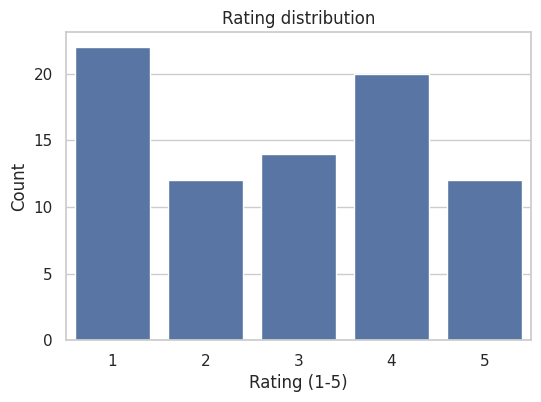

,EventType,Rating
0,Photography Contest,3.300000
1,Robotics Seminar,3.153846
2,Tech Fest,2.888889
3,Hackathon,2.777778
4,Cultural Fest,2.611111
5,Workshop AI,2.583333


In [7]:
# 5) Rating analysis - distributions & top events
rating_col = 'Rating'   # change if necessary
event_col = 'EventType' # change if necessary

# distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x=rating_col, order=sorted(df[rating_col].dropna().unique()))
plt.title('Rating distribution')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.show()

# average rating by event type
avg_by_event = df.groupby(event_col)[rating_col].mean().sort_values(ascending=False).reset_index()
avg_by_event.head(10)

In [8]:
# 6) Sentiment scoring (TextBlob + VADER)
analyzer = SentimentIntensityAnalyzer()

def score_sentiment(text):
    t = str(text)
    # basic clean
    t_clean = re.sub(r'\s+', ' ', t).strip()
    # TextBlob polarity (-1 to 1)
    tb = TextBlob(t_clean).sentiment.polarity
    # VADER compound (-1 to 1)
    vd = analyzer.polarity_scores(t_clean)['compound']
    return pd.Series({'textblob_polarity': tb, 'vader_compound': vd})

sent_df = df['Comments'].apply(score_sentiment)
df = pd.concat([df, sent_df], axis=1)

# simple buckets
df['sentiment_tb'] = pd.cut(df['textblob_polarity'], bins=[-1, -0.05, 0.05, 1], labels=['negative','neutral','positive'])
df['sentiment_vd'] = pd.cut(df['vader_compound'], bins=[-1, -0.05, 0.05, 1], labels=['negative','neutral','positive'])
df[['Comments','textblob_polarity','vader_compound','sentiment_tb','sentiment_vd']].head()


,Comments,textblob_polarity,vader_compound,sentiment_tb,sentiment_vd
0,Too crowded and unorganized.,0.00,0.0000,neutral,neutral
1,Excellent arrangements and hospitality.,1.00,0.5719,positive,positive
2,Great organization and very informative.,0.50,0.6249,positive,positive
3,"Fantastic experience, looking forward to the n...",0.20,0.5574,positive,positive
4,Very engaging and interactive event.,0.52,0.4005,positive,positive


In [9]:
# 7) Sentiment summaries & correlation with ratings
# overall counts
print("TextBlob sentiment counts:\n", df['sentiment_tb'].value_counts())
print("\nVADER sentiment counts:\n", df['sentiment_vd'].value_counts())

# average rating per sentiment (TextBlob)
df.groupby('sentiment_tb')[rating_col].agg(['count','mean']).sort_values('mean', ascending=False)


TextBlob sentiment counts:
 sentiment_tb
positive    52
neutral     17
negative    11
Name: count, dtype: int64

VADER sentiment counts:
 sentiment_vd
positive    48
negative    22
neutral     10
Name: count, dtype: int64


/tmp/ipython-input-2542052121.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('sentiment_tb')[rating_col].agg(['count','mean']).sort_values('mean', ascending=False)


,count,mean
sentiment_tb,,
positive,52,3.653846
neutral,17,1.411765
negative,11,1.272727


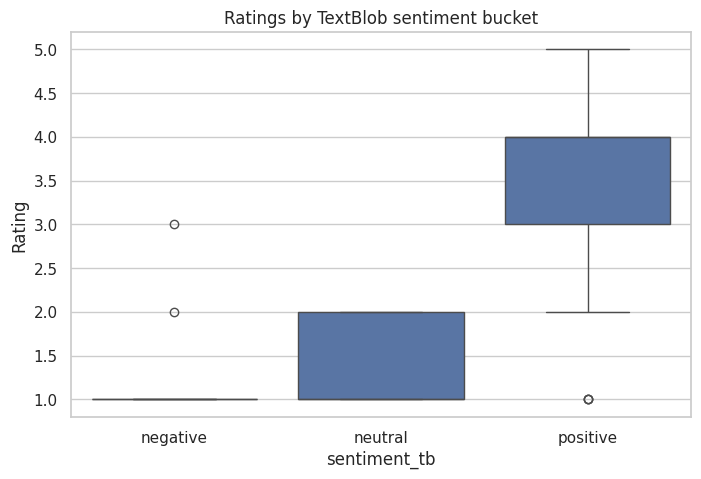

In [10]:
# 8) Visual: sentiment vs rating
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='sentiment_tb', y=rating_col, order=['negative','neutral','positive'])
plt.title('Ratings by TextBlob sentiment bucket')
plt.show()


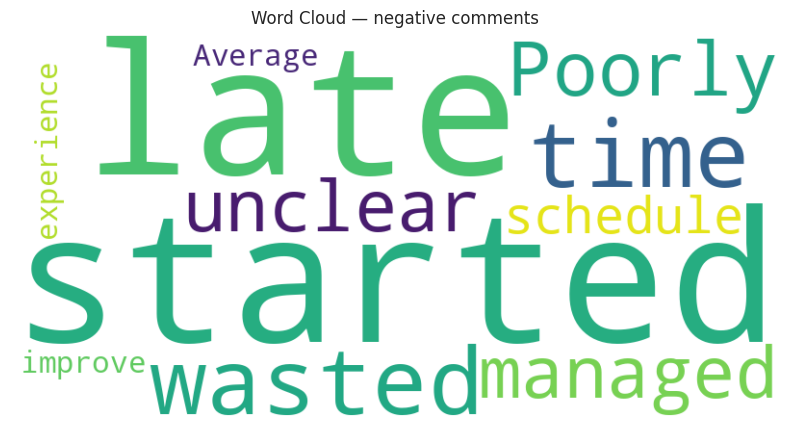

In [11]:
# 9) Word cloud of complaints (negative comments)
neg_comments = " ".join(df.loc[df['sentiment_tb']=='negative', 'Comments'].astype(str).tolist())
stopwords = set(STOPWORDS)
# add common form garbage words
stopwords.update(['please','event','session','https','www','com','thank','thanks'])

wc = WordCloud(width=800, height=400, stopwords=stopwords, background_color='white', collocations=False).generate(neg_comments)

plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud — negative comments')
plt.show()


In [12]:
# 10) Top actionable lists for report
# Top 5 events by avg rating (>= n responses)
min_responses = 5
top_events = df.groupby(event_col).agg(count=(rating_col,'count'), avg_rating=(rating_col,'mean')).query('count >= @min_responses').sort_values('avg_rating', ascending=False).reset_index()
top_events.head(10)

# Most frequent complaint words (simple tokenization)
from collections import Counter
def token_counts(series, n=20):
    text = " ".join(series.astype(str))
    # remove non-alpha, lowercase
    tokens = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    # filter stopwords
    tokens = [t for t in tokens if t not in stopwords]
    return Counter(tokens).most_common(n)

token_counts(df.loc[df['sentiment_tb']=='negative','Comments'], n=25)


[('started', 5),
 ('late', 5),
 ('wasted', 5),
 ('time', 5),
 ('poorly', 5),
 ('managed', 5),
 ('unclear', 5),
 ('schedule', 5),
 ('average', 1),
 ('experience', 1),
 ('improve', 1)]

In [14]:
# 11) Save outputs for the mini-report
df.to_csv('feedback_with_sentiment.csv', index=False)
top_events.to_csv('top_events_summary.csv', index=False)
print("Saved feedback_with_sentiment.csv and top_events_summary.csv")


Saved feedback_with_sentiment.csv and top_events_summary.csv


In [15]:
from google.colab import files
files.download('feedback_with_sentiment.csv')
files.download('top_events_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>